In [ ]:
# Import libraries
import os
import cv2
import json
import numpy as np

# Mount google drive
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
def save_masks(json_path: str, folder: str) -> None: # folder - 6 или 26 дней после заражения
    '''
    draws segmentation masks from vertex coordinates of polygons
    and saves it in desired directory

    Parameters:
    -----------
        json_path:
            path to json file with the following content:
            image name, list of vertex coordinates of polygons determing
            sick regions of the leaves

        folder:
            subfolder where images are stored. There are two possible values:
            "6 дней после заражения" and "26 дней после заражения"

    '''

    def add_to_dict(data, itr, key, count):
        '''
        extracts X and Y coordinates if available and update dictionary

        Parameters:
        -----------
            data:
                nested dict with coordinates of polygon vertex for each image

            itr:
                particular image

            key:
                number of polygon (used for correct counting resulting images)

            count:
                 additional counter for correct numbering
        '''

        try:
            x_points = data[itr]["regions"][count]["shape_attributes"]["all_points_x"]
            y_points = data[itr]["regions"][count]["shape_attributes"]["all_points_y"]
        except:
            print("No BB. Skipping", key)
            return

        all_points = []
        for i, x in enumerate(x_points):
            all_points.append([x, y_points[i]])

        file_bbs[key] = all_points

    file_bbs = {}
    MASK_WIDTH = 512				    # Dimensions should match those of ground truth image
    MASK_HEIGHT = 512
    count = 0

    with open(json_path) as f:
        data = json.load(f)

    for itr in data:
        file_name_json = data[itr]["filename"]
        sub_count = 0               # Contains count of masks for a single ground truth image
        if len(data[itr]["regions"]) > 1:
            for _ in range(len(data[itr]["regions"])):
                key = file_name_json[:-4] + "*" + str(sub_count+1)
                add_to_dict(data, itr, key, sub_count)
                sub_count += 1
        else:
            add_to_dict(data, itr, file_name_json[:-4], 0)

    print("\nDict size: ", len(file_bbs))

    file_keys = list(file_bbs.keys())
    cur_file = file_keys[0].split('*')[0]
    sum_mask = np.zeros((MASK_WIDTH, MASK_HEIGHT))
    gdrive_folder = f'/content/gdrive/MyDrive/Cropped Potato/Разметка/{folder}/Разметка картинки'

    for itr in file_keys:
        cur_itr = itr.split('*')[0]
        if cur_itr != cur_file:
            cv2.imwrite(os.path.join(gdrive_folder, f'{cur_file}.png'), sum_mask)
            sum_mask = np.zeros((MASK_WIDTH, MASK_HEIGHT))
            cur_file = cur_itr
            count += 1

        mask = np.zeros((MASK_WIDTH, MASK_HEIGHT))
        try:
            arr = np.array(file_bbs[itr])
        except:
            print("Not found:", itr)
            continue

        cv2.fillPoly(mask, [arr], color=(255))
        sum_mask += mask

    cv2.imwrite(os.path.join(gdrive_folder, f'{cur_itr}.png'), sum_mask)

    count += 1
    print("Images saved:", count)


In [ ]:
from tqdm.auto import tqdm

# Draw segmentation masks
json_folder_6_days = '/content/gdrive/MyDrive/Cropped Potato/Разметка/6 дней после заражения/Разметка json'
for json_path in tqdm(os.listdir(json_folder_6_days)):
    save_masks(os.path.join(json_folder_6_days, json_path), folder='6 дней после заражения')

  0%|          | 0/9 [00:00<?, ?it/s]


Dict size:  31
Images saved: 2

Dict size:  498
Images saved: 8

Dict size:  772
Images saved: 10

Dict size:  586
Images saved: 10

Dict size:  1622
Images saved: 15

Dict size:  600
Images saved: 5

Dict size:  279
Images saved: 2

Dict size:  706
Images saved: 8

Dict size:  221
Images saved: 4


In [ ]:
# Draw segmentation masks
json_folder_26_days = '/content/gdrive/MyDrive/Cropped Potato/Разметка/26 дней после заражения/Разметка json'
for json_path in tqdm(os.listdir(json_folder_26_days)):
    save_masks(os.path.join(json_folder_26_days, json_path), folder='26 дней после заражения')

  0%|          | 0/8 [00:00<?, ?it/s]


Dict size:  131
Images saved: 3

Dict size:  324
Images saved: 7

Dict size:  589
Images saved: 15

Dict size:  360
Images saved: 10

Dict size:  339
Images saved: 6

Dict size:  531
Images saved: 9

Dict size:  689
Images saved: 7

Dict size:  215
Images saved: 1


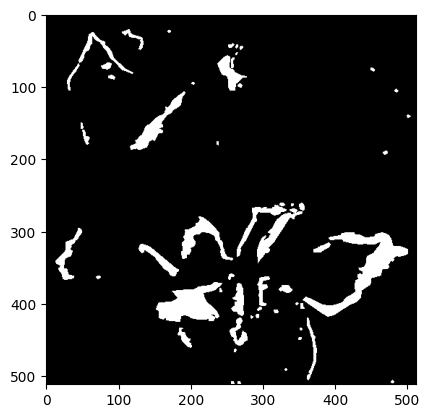

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Check whether it works well
mask_1 = Image.open('/content/gdrive/MyDrive/Cropped Potato/Разметка/26 дней после заражения/Разметка картинки/IMG_70.png')
plt.imshow(mask_1, cmap='gray');